# Waveform processing tools

This notebook introduces a few basic waveform processing tools in the project:
1. [Waveform I/O tools](#waveio)
2. [Waveform pre-emphasis and de-emphasis](#emphasis)
3. [Waveform companding tools](#companding) (i.e., $\mu$-law companding)
4. [Framing and Overlap-add](#overlap)

In [119]:
import os
import sys
import numpy as np
import scipy.io.wavfile

import tool_lib
import plot_lib
import IPython.display

In [120]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

# wrapper functions for plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 12})

def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title):
    axis.plot(x_data, y_data, 'k')
    axis.grid(True)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    return fig, axis

<a id="waveio"></a>
## Waveform I/O tools

We need to read/write waveform from/to disk. 

These tools are defined in git repo `core_scripts/data_io/wav_tools.py`.
For conveninence, we copy and paste the functions here.

Note that
1. These tools deal with waveform data through Numpy array. It will be converted to torch.tensor by Pytorch API.
2. These tools are called in `core_scripts/data_io/default_data_io.py`

```c
waveform data on disk ----> DataSet.__getitem__()  -----> Collate  ---->  Pytorch model
                                numpy.tensor           torch.tensor
                             waveform I/O tools
```

Here we use Scipy tool. 

In [121]:
import os
import sys
import numpy as np
import scipy.io.wavfile

def waveReadAsFloat(wavFileIn):
    """ sr, wavData = wavReadToFloat(wavFileIn)
    Wrapper over scipy.io.wavfile
    Return: 
        sr: sampling_rate
        wavData: waveform in np.float32 (-1, 1)
    """
    sr, wavdata = scipy.io.wavfile.read(wavFileIn)
    
    if wavdata.dtype is np.dtype(np.int16):
        wavdata = np.array(wavdata, dtype=np.float32) / \
                  np.power(2.0, 16-1)
    elif wavdata.dtype is np.dtype(np.int32):
        wavdata = np.array(wavdata, dtype=np.float32) / \
                  np.power(2.0, 32-1)
    elif wavdata.dtype is np.dtype(np.float32):
        pass
    else:
        print("Unknown waveform format %s" % (wavFileIn))
        sys.exit(1)
    return sr, wavdata

def waveFloatToPCMFile(waveData, wavFile, bit=16, sr=16000):
    """waveSaveFromFloat(waveData, wavFile, bit=16, sr=16000)
    Save waveData (np.float32) as PCM *.wav
    
    Args:
       waveData: waveform data as np.float32
       wavFile: output PCM waveform file
       bit: PCM bits
       sr: sampling rate
    """
    
    # recover to 16bit range [-32768, +32767]
    rawData  = waveData * np.power(2.0, bit-1)
    # we set the out-of-range value to the maximum or minimum value
    # we do NOT scale the waveform so that it is between (-1, 1) here
    rawData[rawData >= np.power(2.0, bit-1)] = np.power(2.0, bit-1)-1
    rawData[rawData < -1*np.power(2.0, bit-1)] = -1*np.power(2.0, bit-1)
    
    # write as signed 16bit PCM
    if bit == 16:
        rawData  = np.asarray(rawData, dtype=np.int16)
    elif bit == 32:
        rawData  = np.asarray(rawData, dtype=np.int32)
    else:
        print("Only be able to save wav in int16 and int32 type")
        print("Save to int16")
        rawData  = np.asarray(rawData, dtype=np.int16)
    scipy.io.wavfile.write(wavFile, sr, rawData)
    return

The loaded waveform array has shape:  (44241,)
Its data dtype is  float32
Its sampling rate is 16000 Hz


(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15551df8aac0>)

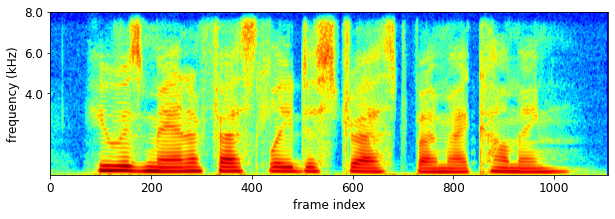

In [122]:
# Load data
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = waveReadAsFloat(wavfile_path)

# check the data shape 
print("The loaded waveform array has shape: ", wave_data.shape)
print("Its data dtype is ", wave_data.dtype)
print("Its sampling rate is {:d} Hz".format(sampling_rate))


# plot the spectrogram
spectrogram = tool_lib.spec_amplitude(wave_data, fft_bins=4096, frame_shift=40, frame_length=240)
fig=plt.figure(figsize=(10,3)); axis=fig.add_subplot(111);
plot_lib.plot_spectrogram(spectrogram, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate)

In [123]:
# Write waveform
# (here we will skip it)
# 
#wavefile_outputpath = './temp.wav'
#waveFloatToPCMFile(wave_data, wavefile_outputpath, bit=16, sr=sampling_rate)

<a id="emphasis"></a>
## Waveform pre-emphasis and de-emphasis

It is a commmon practise to apply pre-emphasis on input waveform.

The algorithm is simple: $x[n] = x[n] - \alpha * x[n-1]$, where $\alpha = 0.97$

Reference:
1. (5.1) of HTKBook https://www.danielpovey.com/files/htkbook.pdf
2. https://librosa.org/doc/main/generated/librosa.effects.preemphasis.html

This technique has been covered at the end of c06_signal_convolution. However, implementation there is based on signal convolution.

Here we implement it again

In [143]:
def _preemphasis(wav, coef):
    """ 
    input: wav, np.array, (length, )
    output: wav_tmp, np.array, (length, )
    """
    wav_tmp = np.zeros_like(wav) + wav
    wav_tmp[1:] = wav_tmp[1:] - coef * wav_tmp[:-1]
    return wav_tmp
    
def _deemphasis(wav, coef):
    """
    input: wav, np.array, (length, )
    output: wav_tmp, np.array, (length, )
    """
    out = np.zeros_like(wav) + wav
    for idx in range(1, wav.shape[0]):
        out[idx] = out[idx] + coef * out[idx-1]
    return out

In [147]:
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = waveReadAsFloat(wavfile_path)

coef = 0.97
# pre-emphasis
wav_preemphasis = _preemphasis(wave_data, coef)
# de-emphasis (reverse it back)
wav_demphasis = _deemphasis(wav_preemphasis, coef)

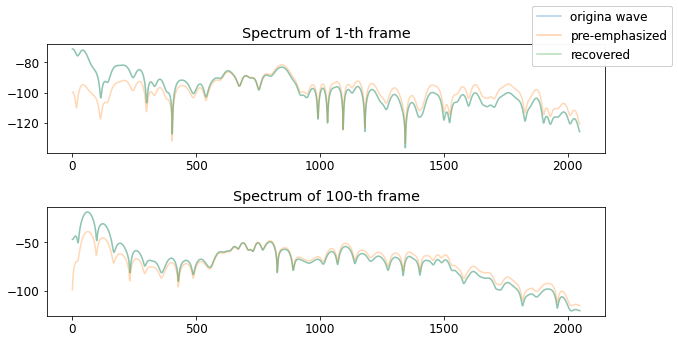

In [159]:
# Plot spectrogram if you prefer
if True:
    spec_wave_data = tool_lib.spec_amplitude(wave_data, fft_bins=4096, frame_shift=40, frame_length=240)
    spec_wave_preemph = tool_lib.spec_amplitude(wav_preemphasis, fft_bins=4096, frame_shift=40, frame_length=240)
    spec_wave_deemph = tool_lib.spec_amplitude(wav_demphasis, fft_bins=4096, frame_shift=40, frame_length=240)
    
    fig=plt.figure(figsize=(10, 5)); 
    # plot one frame
    spec_idx = 1
    axis=fig.add_subplot(211);
    axis.plot(spec_wave_data[:, spec_idx], alpha=0.3)
    axis.plot(spec_wave_preemph[:, spec_idx], alpha=0.3)
    axis.plot(spec_wave_deemph[:, spec_idx], alpha=0.3)
    fig.legend(['origina wave', 'pre-emphasized', 'recovered'])
    axis.set_title("Spectrum of {:d}-th frame".format(spec_idx))
    
    # plot another frame
    spec_idx = 100
    axis=fig.add_subplot(212);
    axis.plot(spec_wave_data[:, spec_idx], alpha=0.3)
    axis.plot(spec_wave_preemph[:, spec_idx], alpha=0.3)
    axis.plot(spec_wave_deemph[:, spec_idx], alpha=0.3)
    fig.legend(['origina wave', 'pre-emphasized', 'recovered'])
    axis.set_title("Spectrum of {:d}-th frame".format(spec_idx))
    fig.subplots_adjust(hspace=0.5)
    
    #axis=fig.add_subplot(312);
    #plot_lib.plot_spectrogram(spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='mulaw-companded waveform (float-valued)')
    #spectrogram = tool_lib.spec_amplitude(wav_demphasis, fft_bins=4096, frame_shift=40, frame_length=240)
    #axis=fig.add_subplot(313);
    #plot_lib.plot_spectrogram(spectrogram, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate, title='waveform recovered from mu-law')
    #fig.subplots_adjust(hspace=0.5)

Notice that the low-frequency band of pre-emphasized waveform is lower -- pre-emphasis changes tilt of the spectrum.

Pre-emphasis can be used to, for example, process the target waveform of WaveNet, and LPCNet.

<a id="companding"></a>
## Waveform companding

In WaveNet and other neural vocoders, $\mu$-law companding is used to process the waveform.

$\mu$-law companding is well explained here https://en.wikipedia.org/wiki/%CE%9C-law_algorithm.

Here we show the code.

Note
1. These tools are in Numpy and are supposed to be used before converting Numpy array into torch.tensor. 
2. For $\mu$-law companding API for torch.tensor, please check `../sandbox/util_dsp.py`
3. The functions do element-wise operation, and there is no need to constrain the input and output array shape
4. Companding can be applied after pre-emphasis:
```c
waveform ---> preemphais() ---> companding() ---> u-law companded waveform
```

In [160]:
def mulaw_encode(x, quantization_channels, scale_to_int=True):
    """x_mu = mulaw_encode(x, quantization_channels, scale_to_int=True)
    
    mu-law companding

    input
    -----
       x: np.array, float-valued waveforms in (-1, 1)
       quantization_channels (int): Number of channels
       scale_to_int: Bool
         True: scale mu-law to int
         False: return mu-law in (-1, 1)

    output
    ------
       x_mu: np.array, mulaw companded wave
    """
    mu = quantization_channels - 1.0
    x_mu = np.sign(x) * np.log1p(mu * np.abs(x)) / np.log1p(mu)
    if scale_to_int:
        x_mu = np.array((x_mu + 1) / 2 * mu + 0.5, dtype=np.int32)
    return x_mu

def mulaw_decode(x_mu, quantization_channels, input_int=True):
    """mulaw_decode(x_mu, quantization_channels, input_int=True)
    
    mu-law decoding

    input
    -----
      x_mu: np.array, mu-law waveform
      quantization_channels: int, Number of channels
      input_int: Bool
        True: convert x_mu (int) from int to float, before mu-law decode
        False: directly decode x_mu (float)

    output
    ------
        x: np.array, waveform from mulaw decoding
    """
    mu = quantization_channels - 1.0
    if input_int:
        x = x_mu / mu * 2 - 1.0
    else:
        x = x_mu
    x = np.sign(x) * (np.exp(np.abs(x) * np.log1p(mu)) - 1.0) / mu
    return x

In [161]:
# Load data
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = waveReadAsFloat(wavfile_path)

# number of bits for companding (or quantization)
num_bit = 10
# number of quantization levelsb
num_quantization_level =2 ** num_bit

In [126]:
# Companding / quantization

# Mulaw companding alogrithm produces float numbers, and a further quantization step is included to convert
#  the mulaw-companded data into integers
# Here we first check the float-valued companded waveform
mulaw_data_float = mulaw_encode(wave_data, num_quantization_level, scale_to_int=False)

# Now check the quantized data
mulaw_data_int = mulaw_encode(wave_data, num_quantization_level, scale_to_int=True)
print("Quantized mu-law data: min: {:d}, max:{:d}".format(mulaw_data_int.min(), mulaw_data_int.max()))

Quantized mu-law data: min: 67, max:991


In [127]:
# De-companding

#  We can recover the waveform from float-valued mu-law data
de_mulaw_wav_fromfloat = mulaw_decode(mulaw_data_float, num_quantization_level, input_int=False)

    
#  We can recover the waveform from mu-law quantized data
de_mulaw_wav_fromint = mulaw_decode(mulaw_data_int, num_quantization_level, input_int=True)

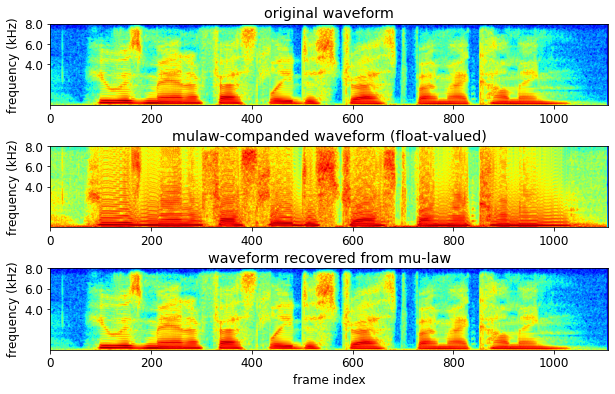

In [128]:
# Plot some figures

# Plot waveform if you prefer
if False:
    xlabel = 'waveform sampling points'
    ylabel = 'amplitude'
    fig=plt.figure(); axis=fig.add_subplot(311);
    plot_data(np.arange(wave_data.shape[0]), wave_data, fig, axis, '', ylabel, 'original waveform')
    axis=fig.add_subplot(312);
    plot_data(np.arange(mulaw_data_float.shape[0]), mulaw_data_float, fig, axis, '', ylabel, 'mu-law companded waveform(float-valued)')
    axis=fig.add_subplot(313);
    plot_data(np.arange(de_mulaw_wav_fromfloat.shape[0]), de_mulaw_wav_fromfloat, fig, axis, '', ylabel, 'waveform recovered from mu-law')
    fig.subplots_adjust(hspace=0.5)

# Plot spectrogram if you prefer
if True:
    spectrogram = tool_lib.spec_amplitude(wave_data, fft_bins=4096, frame_shift=40, frame_length=240)
    fig=plt.figure(); axis=fig.add_subplot(311);
    plot_lib.plot_spectrogram(spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='original waveform')
    spectrogram = tool_lib.spec_amplitude(mulaw_data_float, fft_bins=4096, frame_shift=40, frame_length=240)
    axis=fig.add_subplot(312);
    plot_lib.plot_spectrogram(spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='mulaw-companded waveform (float-valued)')
    spectrogram = tool_lib.spec_amplitude(de_mulaw_wav_fromfloat, fft_bins=4096, frame_shift=40, frame_length=240)
    axis=fig.add_subplot(313);
    plot_lib.plot_spectrogram(spectrogram, fig, axis, "frame index", "frequency (kHz)", sampling_rate = sampling_rate, title='waveform recovered from mu-law')
    fig.subplots_adjust(hspace=0.5)

<a id="overlap"></a>
## Framing and Overlap-add

Motivation to explain framing and overlap-add:
1. Some neural vocoders do not process the whole waveform. Instead, they process the waveform segment by segment, e.g., the voice converter model Blow https://github.com/joansj/blow;
2. Framing and overlap-add is used in LPC and other signal processing tools.

Here, we explain a naive Pytorch implementation. 

Note
1. this is related to https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method but without DFT/IDFT
2. this API is in Pytorch, but implementation using Numpy should be easy 

### Module Definition


1. forward() conducts framing and windowing
2. reverse() conducts overlap-add to reconstruct the waveforms

In this notebook, we also refers to the overlap-added waveform as reconstructed waveform

In [129]:
class OverlapAdder(torch_nn.Module):
    """OverlapAdder
    """
    def __init__(self, fl, fs, flag_win_analysis=True):
        """OverlapAdder(flag_windowing_before=True)
        Args
        ----
          fl: int, frame length
          fs: int, frame shift
          flag_win_analysis: bool (default True)
              True: apply windowing during analysis
              False: apply windowing during synthesis          
        """
        super(OverlapAdder, self).__init__()
        self.fl = fl
        self.fs = fs
        self.flag_win_ana = flag_win_analysis
        
        # assume even 
        self.m_win = torch_nn.Parameter(torch.hann_window(self.fl))
        return
    
    def get_frame_num(self, wav_length):
        """frame_num = get_frame_num(wav_length)
        wav_length: int, waveform length
        frame_num: int, number of frames
        """
        return (wav_length - self.fl) // self.fs + 1
    
    def get_wavlength(self, frame_num):
        """wav_length = get_wavlength(self, frame_num)
        wav_length: int, waveform length
        frame_num: int, number of frames
        """
        return (frame_num - 1) * self.fs + self.fl
    
    def forward(self, x):
        """OverlapAdder(x)
        
        input
        -----
          x: tensor, (batch, length, 1)
        
        output
        ------
          y: tensor, (batch, frame_num, frame_length)
        """
        frame_num = self.get_frame_num(x.shape[1])
        
        # (batch, num_patches, 1, patch_size)
        # num_patches = (length - length) // shift + 1
        # and copy the data
        # note that unfold put each patch as the last dimension
        # x_tmp (batch, frame_num, 1, frame_length)
        x_tmp = x.unfold(1, self.fl, self.fs)

        # apply window
        if self.flag_win_ana:
            x_tmp = x_tmp * self.m_win
            
        # (batch, frame_num, frame_length)
        return x_tmp.view(x.shape[0], x_tmp.shape[1], -1)

    def reverse(self, x_framed, flag_scale=False):
        """OverlapAdder(x)
        
        input
        -----
          x: tensor, (batch, frame_num, frame_length)
          flag_scale: bool, whether scale the ampltidue to (-1, 1)
                      default False
        output
        ------
          y: tensor, (batch, length, 1)
        """
        batch, frame_num, frame_len = x_framed.shape
        x_len = self.get_wavlength(frame_num)
        x_buf = torch.zeros(
            [batch, x_len], device=x_framed.device, dtype=x_framed.dtype)
        x_win = torch.zeros_like(x_buf)
        
        for idx in range(frame_num):
            sdx = idx * self.fs
            edx = sdx + self.fl
            x_win[:, sdx:edx] += self.m_win
            if not self.flag_win_ana: 
                x_buf[:, sdx:edx] += x_framed[:, idx] * self.m_win
            else:
                x_buf[:, sdx:edx] += x_framed[:, idx]
        # assume the overlapped window has a constant amplitude
        x_buf = x_buf / x_win.mean()

        # normalize the amplitude between (-1, 1)
        if flag_scale:
            # if input is between (-1, 1), there is no need to 
            # do this normalization
            x_buf = x_buf / (x_buf.abs().max())
        return x_buf.unsqueeze(-1)


### Example usage

Basic usage of the framing and overlap-add Module:
1. Framed_waveform <- OverlapAdder.forward(Original_waveform)
2. Reconstructed_waveform <- OverlapAdder.reverse(Framed_waveform)


Reconstructed waveform may be different from the original waveform.

Let's try with one example

In [130]:
# Create a framing and overlap adder
frame_length = 320
frame_shift = 80
m_overlapadder = OverlapAdder(frame_length, frame_shift)


# Load data
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = waveReadAsFloat(wavfile_path)
# convert numpy array to tensor in shape (1, wavelength, 1)
wave_data_tensor = torch.tensor(wave_data).unsqueeze(0).unsqueeze(-1)


# Framing (and windowing)
with torch.no_grad():
    framed_wave_tensor = m_overlapadder(wave_data_tensor)


# Overlap and add, i.e., reconstructing the original waveforms
with torch.no_grad():
    reconstructed_wave_tensor = m_overlapadder.reverse(framed_wave_tensor)
    
    
print("Input waveform tensor has shape", wave_data_tensor.shape)
print("Framed waveform tensor has shape", framed_wave_tensor.shape)
print("Reconstructed waveform tensor has shape", reconstructed_wave_tensor.shape)

Input waveform tensor has shape torch.Size([1, 44241, 1])
Framed waveform tensor has shape torch.Size([1, 550, 320])
Reconstructed waveform tensor has shape torch.Size([1, 44240, 1])


'Original waveform'

'Reconstructed waveform'

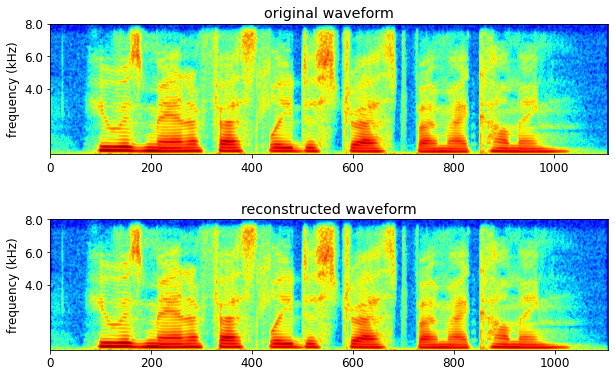

In [131]:
# Let's plot some figures

# convert tensor to numpy for plotting
framed_wave = framed_wave_tensor.numpy()[0]
reconstructed_wave = reconstructed_wave_tensor.numpy()[0, :, 0]


# plot spectrogram if necessary   
if True:
    spectrogram = tool_lib.spec_amplitude(wave_data, fft_bins=4096, frame_shift=40, frame_length=240)
    fig=plt.figure(); axis=fig.add_subplot(211);
    plot_lib.plot_spectrogram(spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='original waveform')
    
    spectrogram = tool_lib.spec_amplitude(reconstructed_wave, fft_bins=4096, frame_shift=40, frame_length=240)
    axis=fig.add_subplot(212);
    plot_lib.plot_spectrogram(spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='reconstructed waveform')
    fig.subplots_adjust(hspace=0.5)
    
IPython.display.display('Original waveform')
IPython.display.display(IPython.display.Audio(wave_data, rate=sampling_rate, normalize=False))
IPython.display.display('Reconstructed waveform')
IPython.display.display(IPython.display.Audio(reconstructed_wave, rate=sampling_rate, normalize=False))

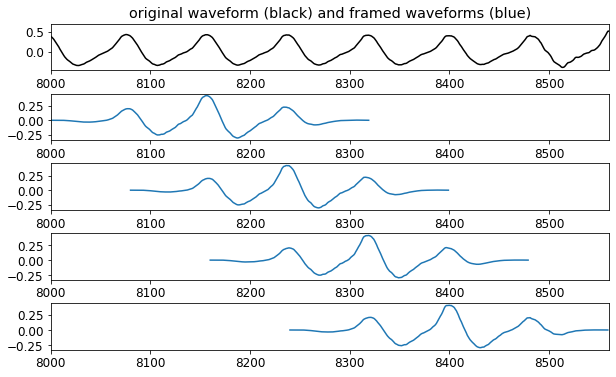

In [132]:
# Let's plot a few frames

# function to the time index of one frame
def frame_time_idx_range(frame_idx, frame_length=frame_length, frame_shift=frame_shift):
    # return the start and end time index of the frame
    return frame_idx * frame_shift, frame_idx * frame_shift + frame_length


frame_indices = [100, 101, 102, 103]
#  the time range to plot the waveforms
plot_xlim = [frame_time_idx_range(frame_indices[0])[0], frame_time_idx_range(frame_indices[-1])[-1]]

# whole waveform
length = wave_data.shape[0]
time_idx = np.arange(length)
fig=plt.figure(); axis=fig.add_subplot(511);
axis.plot(time_idx, wave_data, color='k')
axis.set_title('original waveform (black) and framed waveforms (blue)')
axis.set_xlim(plot_xlim)

# plot a few frames
for figure_idx, frame_idx in enumerate(frame_indices):
    axis=fig.add_subplot(5, 1, figure_idx + 2);
    frame_start, frame_end = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    axis.plot(np.arange(frame_start, frame_end), framed_wave_tensor[0, frame_idx].numpy())
    axis.set_xlim(plot_xlim)
fig.subplots_adjust(hspace=0.5)

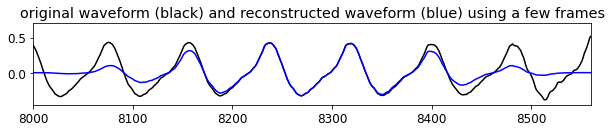

In [133]:
# We can overlap the framed waveform 
# This is basically what OverlapAdder.reverse() does

# create a buffer to store the overlapped waveform
reconstructed_buffer = np.zeros(length)

# overlap & add
for _, frame_idx in enumerate(frame_indices):
    frame_start, frame_end = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    reconstructed_buffer[frame_start : frame_end] += framed_wave_tensor[0, frame_idx].numpy()
# re-scale the ampltiude 
reconstructed_buffer = reconstructed_buffer/2

# plot
fig=plt.figure(figsize=(10, 1.5)); axis=fig.add_subplot(111);
axis.plot(time_idx, wave_data, color='k')
axis.set_title('original waveform (black) and reconstructed waveform (blue) using a few frames')
axis.set_xlim(plot_xlim)
axis.plot(reconstructed_buffer, color='b')


Why `reconstructed_buffer = reconstructed_buffer/2`? It is due to the overlap-add and configuration of the framing -- we are summing two overlapped segments, and the overlapped part may increase in amplitude. More explanation can be found in the next section.

Why the reconstructed waveform has smaller amplitude at the begining and end? It is due to the window. Remember that we use Hann window on each frame. Furthermore, in the figure above we only overlap 4 frames. More explanation can be found in the next section.

The reason to apply the window is to avoid the Gibbs effect (https://en.wikipedia.org/wiki/Gibbs_phenomenon). This is a standard procedure in short-time analysis of signal, for example, STFT (https://en.wikipedia.org/wiki/Short-time_Fourier_transform)

### Some notes

The overlap-added waveform may be different from the original waveform
1. the length may be different because of the framing operation
2. the overlap-added waveform amplitude may be different due to the window


**On waveform length**

This API does not do pad the waveform, instead, it trim waveform points that don't fit in the last frame.

Number_of_output_frame = (waveform length - frame_length) // frame_shift + 1

See OverlapAdder.get_frame_num()


**On window**

This is related to the questions we asked in the previous section. 

This API uses Hann window https://en.wikipedia.org/wiki/Hann_function. It is nice because when overlap-adding Hann windows, we can get a flat ampltiude on the overlapped regions. See examples below

It is easier to understand the impact of window using a simple example -- a waveform with constant value.

To show the impact of framing configuration, two overlap-adder will be used.


In [134]:
# Let's use a constant-valued signal as example
length = 1000
example_wav_tensor = torch.ones([1, length, 1])

# Create a framing and overlap adder 1
frame_length1 = 320
frame_shift1 = 80
m_overlapadder1 = OverlapAdder(frame_length1, frame_shift1)

# Create a framing and overlap adder 2
frame_length2 = 320
frame_shift2 = 160
m_overlapadder2 = OverlapAdder(frame_length2, frame_shift2)


with torch.no_grad():
    # framed wave
    framed_wave_tensor1 = m_overlapadder1(example_wav_tensor)
    framed_wave_tensor2 = m_overlapadder2(example_wav_tensor)

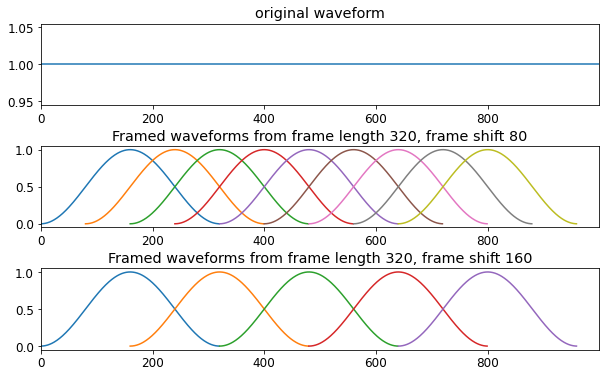

In [135]:
# plot figures
def frame_time_idx_range(frame_idx, frame_length, frame_shift):
    # return the start and end time index of the frame
    return frame_idx * frame_shift, frame_idx * frame_shift + frame_length

# whole waveform
time_idx = np.arange(length)
fig=plt.figure(); axis=fig.add_subplot(311);
axis.plot(time_idx, example_wav_tensor.numpy()[0, :, 0])
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('original waveform')

# plot each frames from overlapp adder 1
frame_num1 = framed_wave_tensor1.shape[1]
axis=fig.add_subplot(312);
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor1[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length1, frame_shift1))


# plot each frames from overlapp adder 2
frame_num2 = framed_wave_tensor2.shape[1]
axis=fig.add_subplot(313);
for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor2[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length2, frame_shift2))


fig.subplots_adjust(hspace=0.5)

Notice:

1. how the last frame doesn't cover the end of the original waveform. This API simply discard that part. Notice that other tools may pad the original waveform instead.
2. frames overlap with each other, and the overlapped length is decided by the frame shift (, which is the reason that some tools specifies overlap length rather than frame shift length)

Now let's add the framed (and windowed) waveforms back

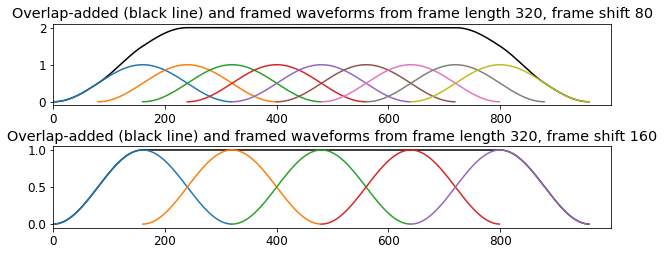

In [136]:
# Length of reconstructed waveform   
#  see OverlapAdder.get_wavlength()
reconstructed_waveform_length1 = (frame_num1 - 1) * frame_shift1 + frame_length1
reconstructed_waveform_buffer1 = np.zeros([reconstructed_waveform_length1])

reconstructed_waveform_length2 = (frame_num2 - 1) * frame_shift2 + frame_length2
reconstructed_waveform_buffer2 = np.zeros([reconstructed_waveform_length2])


# overlap
# see OverlapAdder.reverse()
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    reconstructed_waveform_buffer1[start_idx:end_idx] += framed_wave_tensor1[0, frame_idx].numpy()
    
for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    reconstructed_waveform_buffer2[start_idx:end_idx] += framed_wave_tensor2[0, frame_idx].numpy()


# plot figures for configuration 1
fig=plt.figure(); axis=fig.add_subplot(311);
# plot the overlapped waveform
axis.plot(np.arange(reconstructed_waveform_length1), reconstructed_waveform_buffer1, color='k')
# plot each frame for reference
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor1[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Overlap-added (black line) and framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length1, frame_shift1))


# plot figures for configuration 1
axis=fig.add_subplot(312);
# plot the overlapped waveform
axis.plot(np.arange(reconstructed_waveform_length2), reconstructed_waveform_buffer2, color='k')
# plot each frame for reference
for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor2[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Overlap-added (black line) and framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length2, frame_shift2))

fig.subplots_adjust(hspace=0.5)

Three mesages from figure above
1. The middle part of the overlapped waveform is roughly constant, while the starting and ending parts are gradually increasing / decreasing. This is due to the window;

2. Given a proper frame shift, the overlapped Hann window will be a constant value. (You can try other frame shifts ;)

3. The amplitude of overlapped waveform is decided by the window type and frame shift;

4. The bottom figures shows the good point of Hann window: overlap the first and second half of the Hann window leads to a constant value

For the 3rd point, when doing overlap on the target waveform in OverlapAdder.reverse(), I compute the overlapped  window (in x_win) and use `x_buf = x_buf / x_win.mean()` to re-scale the amplitude. This is not a good solution but a good starting point :)

That's all!